# Processing data using Spark Dataframe with Pyspark

View spark version. If you get an error, you need to troubleshoot the reason further.

In [1]:
spark.version

'2.3.0'

### Exercise 5: use movielens dataset for the following exercise

1. Load movies.csv as movies dataframe. Cache the dataframe
2. Load ratings.csv as ratings dataframe. Cache the dataframe
3. Find the number of records in movies dataframe
4. Find the number of records in ratings dataframe
5. Validate the userId and movieId combination is unique
6. Find average rating and count of rating per movieId using ratings dataframe
7. Find top 10 movies based on the highest average ratings. Consider only those movies that have at least 100 ratings. Show movieId, title, average rating and rating count columns.
8. Show temporary views for current Spark session
9. Register movies dataframe and ratings dayaframe as movies and ratings temporary view respectively. Verify that you can see the new temporary views you just created.
10. Using SQL statement, solve the problem statement for step #7. Match the results from step #7.

Load Spark SQL functions, for example: count, avg, explode etc.

In [2]:
from pyspark.sql.functions import *

Location of movies dataset. You can download the dataset from here. Here we are using latest-small dataset.

In [3]:
home_dir = "/user/cloudera/movielens/"

Create a dataframe on movies.csv file

In [4]:
movies = (spark.read.format("csv")
.options(header = True, inferSchema = True)
.load(home_dir + "movies.csv")
.cache()) # Keep the dataframe in memory for faster processing 

Show schema of movies dataframe

In [5]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
movies.dtypes

[('movieId', 'int'), ('title', 'string'), ('genres', 'string')]

Display a few sample view from movies Dataframe

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Find the number of records in movies dataframe

In [8]:
movies.count()

10329

Create ratings Dataframe using ratings.csv file

In [9]:
ratings = (spark.read.format("csv")
.options(header = True, inferSchema = True)
.load(home_dir + "ratings.csv")
.persist())

Print schema of ratings Dataframe

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Show a few sample values from ratings dataframe

In [11]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     16|   4.0|1217897793|
|     1|     24|   1.5|1217895807|
|     1|     32|   4.0|1217896246|
|     1|     47|   4.0|1217896556|
|     1|     50|   4.0|1217896523|
+------+-------+------+----------+
only showing top 5 rows



Find the number of records in ratings

In [12]:
ratings.count()

105339

Validate the movieId and ratingId combination is unique identifier in ratings table

In [13]:
ratings.groupBy("movieId", "userId").count().filter("count != 1").show()

+-------+------+-----+
|movieId|userId|count|
+-------+------+-----+
+-------+------+-----+



As it shows that there is no userId and movieId combination that occurs more than once. 

Find average rating of each movie for which there are at least 100 ratings. Order the result by average rating in decreasing order.

In [14]:
ratings_agg = (ratings
.groupBy(col("movieId"))
.agg(
    count(col("movieId")).alias("count"),
    avg(col("rating")).alias("avg_rating")
))

ratings_agg.show()

+-------+-----+------------------+
|movieId|count|        avg_rating|
+-------+-----+------------------+
|   1580|  172| 3.627906976744186|
|    471|   48|3.6666666666666665|
|   7253|    2|               4.0|
|   3997|   11|               2.5|
|  32460|    1|               4.5|
|  44022|   16|            3.3125|
|  54190|    7| 3.357142857142857|
|    833|   10|              2.95|
|   1591|   33| 2.257575757575758|
|   6357|    5|               3.6|
|   2366|   31| 3.532258064516129|
|   1088|   56| 3.419642857142857|
|   1238|   12|              3.75|
|   4519|   11|3.0454545454545454|
|   1645|   60| 3.566666666666667|
|   8638|   18|3.9722222222222223|
|   3175|   73| 3.712328767123288|
|   2122|   14|2.2142857142857144|
|  26755|    1|               0.5|
|   5803|    7|2.5714285714285716|
+-------+-----+------------------+
only showing top 20 rows



In [15]:
(ratings_agg
.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.filter("count > 100")
.orderBy(desc("avg_rating"))
.select("t1.movieId", "title", "avg_rating", "count")
.limit(10)
.show())

+-------+--------------------+------------------+-----+
|movieId|               title|        avg_rating|count|
+-------+--------------------+------------------+-----+
|    318|Shawshank Redempt...| 4.454545454545454|  308|
|    858|Godfather, The (1...| 4.392857142857143|  210|
|     50|Usual Suspects, T...| 4.328947368421052|  228|
|   1136|Monty Python and ...|4.3019480519480515|  154|
|    527|Schindler's List ...| 4.296370967741935|  248|
|   1193|One Flew Over the...|4.2727272727272725|  143|
|    608|        Fargo (1996)|4.2711442786069655|  201|
|   2571|  Matrix, The (1999)| 4.264367816091954|  261|
|   1221|Godfather: Part I...| 4.260714285714286|  140|
|   1213|   Goodfellas (1990)|4.2592592592592595|  135|
+-------+--------------------+------------------+-----+



Show temporary views for current Spark session

In [16]:
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   movies|      false|
| default|  weblogs|      false|
+--------+---------+-----------+



In [17]:
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   movies|      false|
| default|  weblogs|      false|
|        |   movies|       true|
|        |  ratings|       true|
+--------+---------+-----------+



Using SQL statement, find top 10 movies based on the highest average ratings. Consider only those movies that have at least 100 ratings. Show movieId, title, average rating and rating count columns.

In [18]:
sql("""

select 
    t1.movieId, 
    t1.title, 
    avg(t2.rating) avg_rating, 
    count(1) rating_count 
from movies t1 join ratings t2 on t1.movieId = t2.movieId 
group by t1.movieId, t1.title
having rating_count >= 100
order by avg_rating desc 
limit 10

""").show()

+-------+--------------------+------------------+------------+
|movieId|               title|        avg_rating|rating_count|
+-------+--------------------+------------------+------------+
|    318|Shawshank Redempt...| 4.454545454545454|         308|
|    858|Godfather, The (1...| 4.392857142857143|         210|
|     50|Usual Suspects, T...| 4.328947368421052|         228|
|   1136|Monty Python and ...|4.3019480519480515|         154|
|    527|Schindler's List ...| 4.296370967741935|         248|
|   1193|One Flew Over the...|4.2727272727272725|         143|
|    608|        Fargo (1996)|4.2711442786069655|         201|
|   2571|  Matrix, The (1999)| 4.264367816091954|         261|
|   1221|Godfather: Part I...| 4.260714285714286|         140|
|   1213|   Goodfellas (1990)|4.2592592592592595|         135|
+-------+--------------------+------------------+------------+



# Find average rating of each genre (advanced)

In [19]:
genre_avg_rating = (ratings.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.select(col("rating"), explode(split("genres", r"\|")).alias("genre"))
.groupBy(col("genre"))
.agg(count(col("genre")).alias("count"), avg("rating").alias("avg_rating"))
.orderBy(desc("avg_rating")))

genre_avg_rating.show()

+------------------+-----+------------------+
|             genre|count|        avg_rating|
+------------------+-----+------------------+
|         Film-Noir| 1210|3.9136363636363636|
|               War| 5828|3.7832017844886754|
|           Mystery| 8320| 3.652043269230769|
|             Drama|46960|3.6502661839863713|
|       Documentary| 1206|3.6430348258706466|
|             Crime|18291|3.6423924334372098|
|              IMAX| 3032| 3.641820580474934|
|         Animation| 5966|3.6353503184713376|
|           Musical| 4287|  3.57196174480989|
|           Western| 2314| 3.565687121866897|
|           Romance|19094| 3.544254739708809|
|         Adventure|23076| 3.518027387762177|
|           Fantasy|10889|3.5004591789879695|
|          Thriller|29288|3.4955613220431574|
|            Sci-Fi|16795|3.4544805001488537|
|            Action|31205|3.4514500881269026|
|          Children| 8098|3.4394294887626575|
|            Comedy|38055|3.4209959269478385|
|            Horror| 7983| 3.28109

### Using matplotlib show barplot of average rating for each genre (Optional)

Loading matplotlib library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Convert spark dataframe to Pandas Dataframe. 

In [21]:
df = genre_avg_rating.toPandas()
df.head()

,genre,count,avg_rating
0,Film-Noir,1210,3.913636
1,War,5828,3.783202
2,Mystery,8320,3.652043
3,Drama,46960,3.650266
4,Documentary,1206,3.643035


Plot average rating for each genre

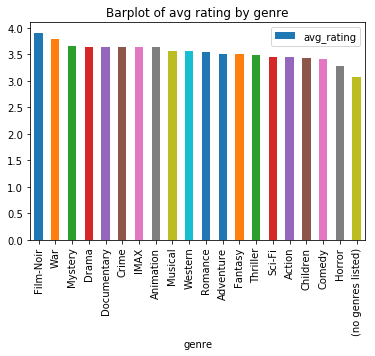

In [22]:
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre")

Check the storage table in Spark Web UI. You can find Spark Web UI as below.

In [88]:
sc.uiWebUrl

'http://quickstart.cloudera:4041'

In [89]:
stocksDf = spark.read.option("header", True).option("inferSchema", True).csv("stocks")
stocksDf.cache()
stocksDf.count()

1857092